<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/marcoteran/ml/blob/master/notebooks/ml_knnandoverfitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Abrir en Colab" title="Abrir y ejecutar en Google Colaboratory"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/marcoteran/ml/blob/master/notebooks/ml_knnandoverfitting.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Abrir en Kaggle" title="Abrir y ejecutar en Kaggle"/></a>
  </td>
</table>

# Sesión 03: Clasificación no lineal, complejidad y sobreajuste
## Guía Completa

**Machine Learning**

**Profesor:** Marco Terán  
**Fecha:** 2025

[Website](http://marcoteran.github.io/),
[Github](https://github.com/marcoteran),
[LinkedIn](https://www.linkedin.com/in/marcoteran/).
___

Definimos primero unas librerías y funciones que vamos a usar a durante la sesión:

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pylab as pl
from sklearn.datasets import make_moons

RANDOM_SEED=82

# Función para visualizar un conjunto de datos en 2D
def plot_data(X, y):
    y_unique = np.unique(y)
    colors = pl.cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
    for this_y, color in zip(y_unique, colors):
        this_X = X[y == this_y]
        pl.scatter(this_X[:, 0], this_X[:, 1],  c=color,
                    alpha=0.5, edgecolor='k',
                    label="Class %s" % this_y)
    pl.legend(loc="best")
    pl.title("Data")
    
# Función para visualizar de la superficie de decisión de un clasificador
def plot_decision_region(X, pred_fun):
    min_x = np.min(X[:, 0])
    max_x = np.max(X[:, 0])
    min_y = np.min(X[:, 1])
    max_y = np.max(X[:, 1])
    min_x = min_x - (max_x - min_x) * 0.05
    max_x = max_x + (max_x - min_x) * 0.05
    min_y = min_y - (max_y - min_y) * 0.05
    max_y = max_y + (max_y - min_y) * 0.05
    x_vals = np.linspace(min_x, max_x, 100)
    y_vals = np.linspace(min_y, max_y, 100)
    XX, YY = np.meshgrid(x_vals, y_vals)
    grid_r, grid_c = XX.shape
    ZZ = np.zeros((grid_r, grid_c))
    for i in range(grid_r):
        for j in range(grid_c):
            ZZ[i, j] = pred_fun(XX[i, j], YY[i, j])
    pl.contourf(XX, YY, ZZ, 100, cmap = pl.cm.coolwarm, vmin= -1, vmax=2)
    pl.colorbar()
    pl.xlabel("x")
    pl.ylabel("y")
    
def gen_pred_fun(clf):
    def pred_fun(x1, x2):
        x = np.array([[x1, x2]])
        return clf.predict(x)[0]
    return pred_fun

Un modelo de clasificación puede ser tan complejo como para aprenderse de memoria el conjunto de entrenamiento. Esta complejidad está determinada por los parámetros internos del modelo. A continuación, observaremos como se comporta esta complejidad usando un modelo clasificación no lineal como lo es  *k-vecinos más cercanos* (K-nearest neighbors en inglés)

## Definición del conjunto de datos

Vamos a trabajar con un conjunto de datos artificial. El conjunto es creado usando la funcionalidad `make_moons` de Scikit-Learn. `make_moons` permite introducir algo de ruido sobre las muestras creadas.

In [3]:
X, y = make_moons(n_samples=600, noise=0.3, random_state=RANDOM_SEED)

In [4]:
print('X ~ n_muestras x n_características:', X.shape)
print('y ~ n_muestras:', y.shape)

print('\nPrimeras 5 muestras:\n', X[:5, :])
print('\nPrimeras 5 etiquetas:', y[:5])

X ~ n_muestras x n_características: (600, 2)
y ~ n_muestras: (600,)

Primeras 5 muestras:
 [[ 1.32679548  0.21438209]
 [-0.67694259  0.58530405]
 [ 0.46931423 -0.18504435]
 [-0.24297507  0.93912253]
 [ 1.29590745 -0.23151242]]

Primeras 5 etiquetas: [0 0 1 0 1]


/tmp/ipykernel_235524/3171386236.py:15: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  pl.scatter(this_X[:, 0], this_X[:, 1],  c=color,


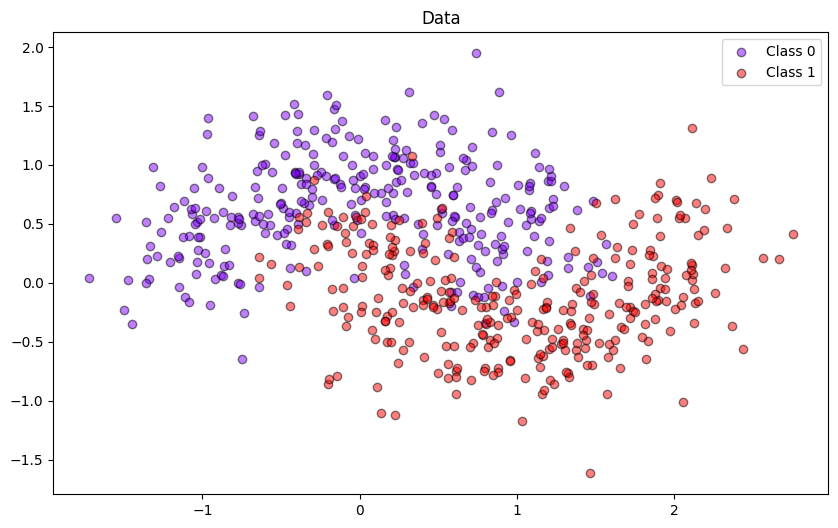

In [5]:
pl.figure(figsize = (10, 6))  
plot_data(X, y)

Observamos que es dificil establecer una separación lineal como en regresión logística. Por lo tanto es necesario usar un modelo de clasificación no lineal.

# Algoritmo: K-vecinos más cercanos

La clasificación basada en vecinos es un tipo de aprendizaje basado en ejemplos. El modelo almacena los ejemplos vistos durante entrenamiento y clasifica un elemento no visto, usando una simple regla de votación por mayoría. Si se ubica un **punto** en el espacio de características, se le asigna como clase el valor de la clase que tenga la mayor cantidad de ejemplos en la vecindad del punto. Este ejemplo lo podemos ver ilustrado en la imagen:

<img src="./figures/knn.png" width="50%">

Scikit-Learn provee una implementación del algoritmo conocida como `KNeighborsClassifier`. `KNeighborsClassifier` tiene un parámetro $n\_neighbors$ o $k$, dónde $k$ es un entero definido por el usuario que determina cuantos vecinos evalua para determinar la clase de una instancia nunca antes vista. La elección de este parámetro es definida totalmente por la naturaleza de los datos.

Observaremos que dependiendo del valor de vecinos más cercanos, conseguimos diferentes funciones de ajuste, unas más suaves que otras. Vamos a evaluar el efecto del parámetro $k$ en la complejidad del modelo. 

In [6]:
from sklearn.neighbors import KNeighborsClassifier

In [7]:
knn = KNeighborsClassifier(n_neighbors=1)

Vamos a extraer un porcentaje al azar del conjunto de datos. 

In [8]:
idx = np.random.choice(len(X), int(len(X)*.5), replace=False)
X_reduced = X[idx]
y_reduced = y[idx]

Entrenamos un modelo `knn` llamando la función `fit()` sobre el conjunto de datos reducido

In [9]:
knn.fit(X_reduced, y_reduced)

,n_neighbors,1
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


/tmp/ipykernel_235524/3171386236.py:15: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  pl.scatter(this_X[:, 0], this_X[:, 1],  c=color,


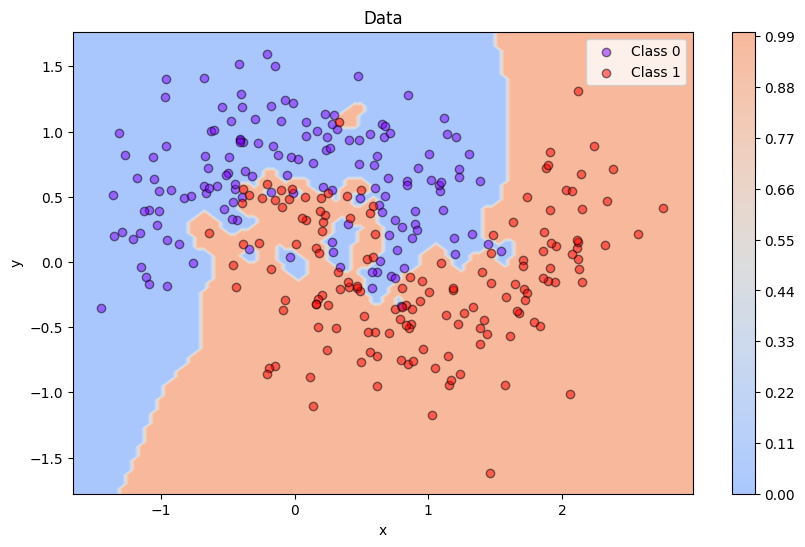

In [14]:
pl.figure(figsize = (10, 6))
plot_decision_region(X_reduced, gen_pred_fun(knn))
plot_data(X_reduced, y_reduced)

In [15]:
print('Error: {}'.format(1 - knn.score(X_reduced, y_reduced)))

Error: 0.0


**¿Tiene sentido que el error sea del $0\%$?**

Ahora agreguemos los datos que descartamos anteriormente

/tmp/ipykernel_235524/3171386236.py:15: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  pl.scatter(this_X[:, 0], this_X[:, 1],  c=color,


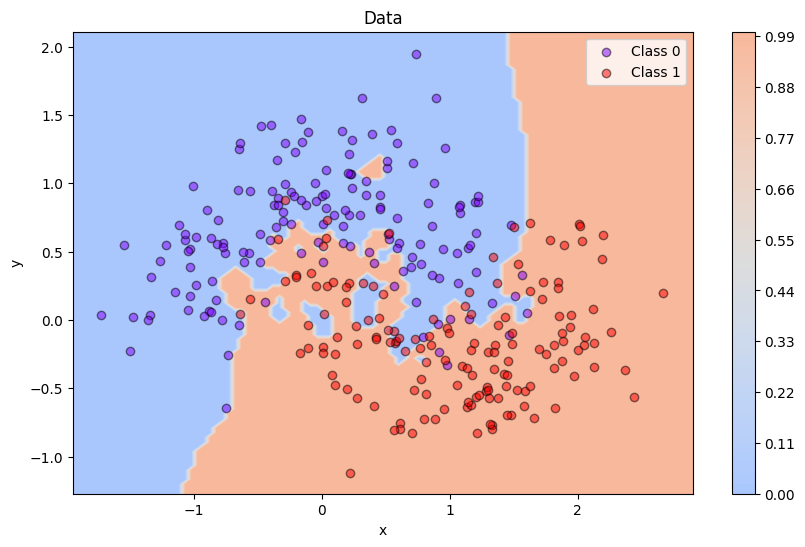

In [18]:
idx_c = [i for i in range(len(X)) if i not in idx]
X_complement = X[idx_c]
y_complement = y[idx_c]

pl.figure(figsize = (10, 6))   
plot_decision_region(X_complement, gen_pred_fun(knn))
plot_data(X_complement, y_complement)

In [19]:
print('Error: {}'.format(1 - knn.score(X_complement, y_complement)))

Error: 0.13666666666666671


Podemos observar que cuando el número de vecinos es $1$, el modelo se ajusta demasiado al ruído de los datos de entrada, por lo tanto sufre de **sobreajuste**.

# Error de entrenamiento y generalización

Un modelo de aprendizaje de máquina tiene como objetivo principal hacer predicciones de manera acertada sobre ejemplos nunca antes vistos por el modelo. Esto se conoce como error de generalización. Para poder medir el error de generalización, dividimos el conjunto de datos en dos particiones: 

* **Entrenamiento**: Se usará para entrenar el modelo.
* **Prueba**: Se usará para medir el error de generalización.

En la siguiente imagen encontramos una ilustración de cómo se hace un particionamiento en entrenamiento y prueba.

<img src="./figures/train_test_split.svg" width="50%">

Una de las prácticas recomendadas, es particionar los datos $70\%$ para entrenamiento y $30\%$ para prueba. Cuando el número de muestras es muy grande ($\ge 70K$), podemos reducir el porcentaje de muestras para prueba, a $90-10\%$. Sin embargo, deben hacerse unas aclaraciones sobre la generalización:

* El conjunto de prueba debe ser una muestra representativa del conjunto de datos. El muestreo de ejemplos debe hacerse de forma independiente e idénticamente aleatoria de una distribución. Esto quiere decir, que el muestreo de un ejemplo no está influenciado por el muestreo de otro.
* La distribución es estacionaria. Es decir no cambia a lo largo del conjunto de datos.
* Los ejemplos son muestreados desde particiones de la misma distribución. Es decir, no se deben crear nuevas características en la partición de prueba.

Adicionalmente, debemos tener en cuenta que se conserve la distribución de las etiquetas de los datos tanto en entrenamiento como en prueba (estratificación). En la siguiente sesión se va a estudiar en más detalle los efectos de hacer una partición estratificada. Scikit-Learn nos permite particionar un conjunto de datos en entrenamiento y prueba. A continuación vamos a dividir el conjunto en $70\%$ para entrenamiento y $30\%$ para prueba.

In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3, 
                                                    random_state=RANDOM_SEED,
                                                    stratify=y)

#### Parámetros:

* `test_size`: Tamaño de la partición de prueba
* `random_state`: Semilla del generador de números pseudoaleatorios. Este parámetro garantiza reproducibilidad del particionamiento.
* `stratify`: Si se estratifican los datos con respecto a `y`

Vamos a verificar el número de muestras de ambas particiones y la distribución de clases de cada una.

In [28]:
print('Número de muestras en entrenamiento: {}'.format(X_train.shape[0]))
print('Número de muestras en prueba: {}'.format(X_test.shape[0]))
print('Número de características: {}'.format(X_train.shape[1]))

print('Distribución de clases en entrenamiento: {}'.format(np.bincount(y_train)))
print('Distribución de clases en prueba: {}'.format(np.bincount(y_test)))

Número de muestras en entrenamiento: 420
Número de muestras en prueba: 180
Número de características: 2
Distribución de clases en entrenamiento: [210 210]
Distribución de clases en prueba: [90 90]


Usamos la partición recién creada y analizamos un modelo entrenado con $k = 200$.

In [29]:
knn = KNeighborsClassifier(n_neighbors=200)
knn.fit(X_train, y_train)

,n_neighbors,200
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


/tmp/ipykernel_235524/3171386236.py:15: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  pl.scatter(this_X[:, 0], this_X[:, 1],  c=color,


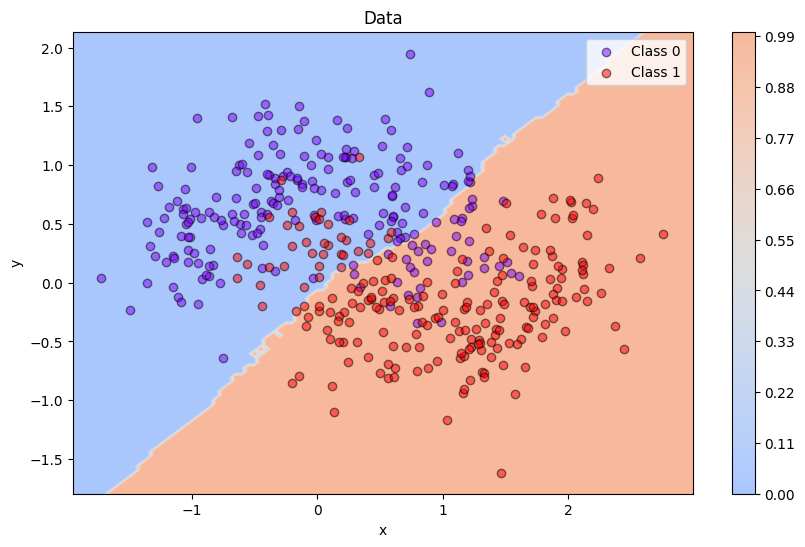

In [30]:
pl.figure(figsize = (10, 6)) 
plot_decision_region(X_train, gen_pred_fun(knn))
plot_data(X_train, y_train)

In [31]:
print('Error en entrenamiento: {}'.format(1-knn.score(X_train, y_train)))

Error en entrenamiento: 0.18095238095238098


Observamos que el error en entrenamiento es del $18\%$. Además se evidencia que el modelo entrenado es ahora demasiado **simple** y no se puede ajustar la estructura de los datos.

Ahora medimos el error de generalización del modelo entrenado y visualizamos la clasificación de los datos de prueba.

/tmp/ipykernel_235524/3171386236.py:15: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  pl.scatter(this_X[:, 0], this_X[:, 1],  c=color,


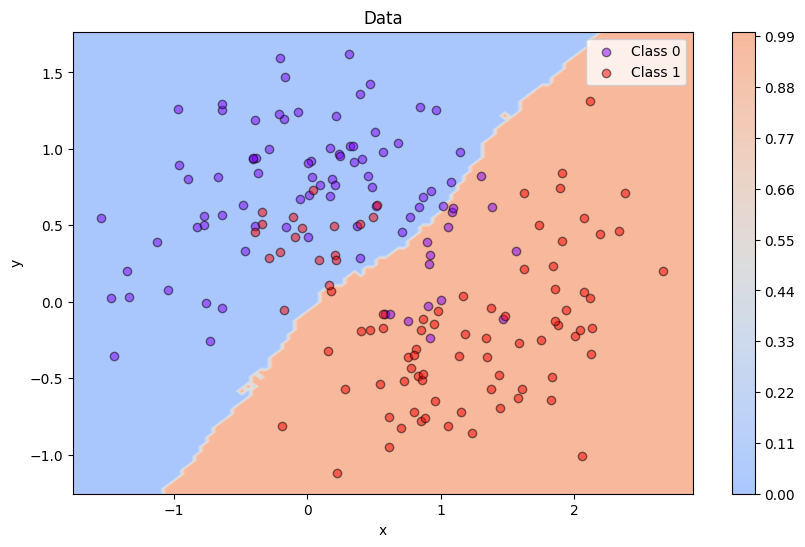

In [32]:
pl.figure(figsize = (10, 6))   
plot_decision_region(X_test, gen_pred_fun(knn))
plot_data(X_test, y_test)

In [33]:
print('Error de generalización: {}'.format(1 - knn.score(X_test, y_test)))

Error de generalización: 0.18888888888888888


Podemos observar que cuando aumentamos el número de vecinos, nuestro modelo sufre de **subajuste**. La superficie de decisión se suaviza, pero no logra captar los detalles de los datos. Mientras el error de entrenamiento se acerca a $18\%$, el error de generalización se acerca a $18\%$.

**¿Cómo estimar un buen número de $k$-vecinos más cercanos de manera que el modelo no sobreajuste ni subajuste los datos?**

# Evaluación de la complejidad

Un modelo de aprendizaje de máquina puede ser tan complejo como para recordar las particularidades y el ruido del conjunto de entrenamiento (**sobreajuste**), así como puede ser demasiado flexible para no modelar la variabilidad de los datos (**subajuste**). El modelo debe garantizar un compromiso entre el sobreajuste y el subajuste, lo cual se logra evaluando la complejidad del modelo. Una forma de evaluar la complejidad es analizar el error de entrenamiento y generalización para diferentes modelos que varían en su complejidad. En el caso de `KNearestNeighbor`, la complejidad está determinada por el número de vecinos $k$. **Entre menor sea el número de vecinos, más complejo es el modelo.**

A continuación exploramos un conjunto de valores $k$, con el objetivo de encontrar aquel modelo con el mejor compromiso entre error de entrenamiento y error de generalización.

In [34]:
k_values = list(range(1, 20))
print(k_values)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


Vamos a generar un nuevo conjunto de datos con $1000$ muestras y haremos una partición $70-30$.

In [35]:
X, y = make_moons(n_samples=1000, noise=0.4, random_state=RANDOM_SEED)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3, 
                                                    random_state=RANDOM_SEED,
                                                    stratify=y)

Guardamos el error de entrenamiento y generalización con respecto al aumento de complejidad del modelo.

In [36]:
train_error = []
generalization_error = []

for nn in k_values:
    knn = KNeighborsClassifier(n_neighbors=nn)
    knn.fit(X_train, y_train)
    train_error.append(1 - knn.score(X_train, y_train))
    generalization_error.append(1 - knn.score(X_test, y_test))

Visualizamos ambas curvas de aprendizaje.

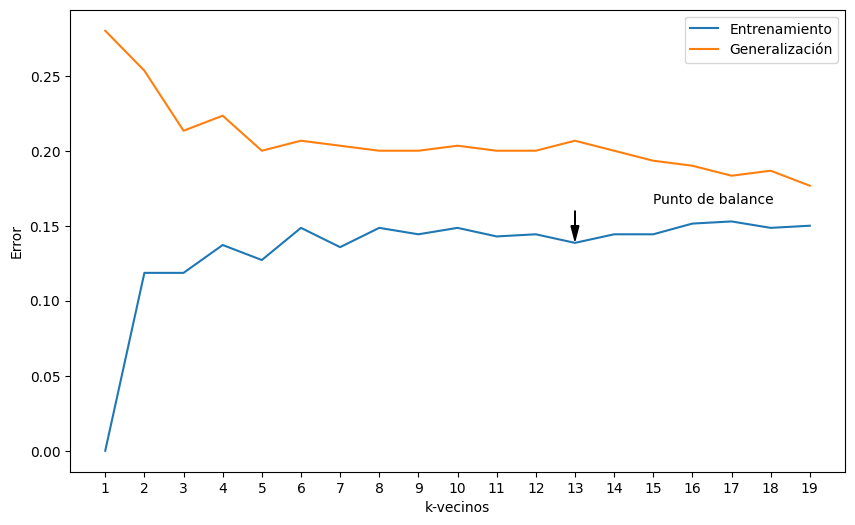

In [37]:
pl.figure(figsize = (10, 6))

pl.plot(k_values, train_error, label="Entrenamiento")
pl.plot(k_values, generalization_error, label="Generalización")
pl.xticks(k_values)
pl.xlabel("k-vecinos")
pl.ylabel("Error")
#pl.gca().invert_xaxis()
pl.arrow(13, 0.16, 0, -0.01, head_width=0.2, head_length=0.01, fc='k', ec='k')
pl.text(15, 0.165, 'Punto de balance')
pl.legend();

Encontramos que el error de entrenamiento y generalización tiene su punto de balance mínimo con $k=13$. Observamos tambien que cuando el modelo es demasiado complejo ($k=1$), el error de generalización sube, así como el de entrenamiento cae a $0\%$.

# Taller

Siguiendo con el conjunto de datos **Wine**.

# Realice:

* Cargue el conjunto de datos **Wine**.
* Genere una partición estratificada 70-30 sobre el conjunto de datos.
* Genere una gráfica de barras en Pandas que verifique que las particiones de entrenamiento y prueba tengan la misma distribución de clases.

## Explorando la complejidad usando `KNearestNeighbor`
* Entrene un modelo `KNearestNeighbor`. Use los siguientes valores para evaluar la complejidad:
    * $[1, 2, 3, \dots, 20]$
    * Grafique los errores de entrenamiento y generalización conforme a la complejidad el modelo aumenta.
* Construya un conjunto de datos usando las características `Proline` contra `Flavonoids`. 
    * Use la partición 70-30 definida al inicio
    * Usando `KNearestNeighbor`, determine el número subóptimo de k-vecinos usando evaluación de la complejidad. Use los mismos valores de $k$: $[1, 2, 3, \dots, 20]$
    * Grafique la superficie de decisión contra los ejemplos de test.
    * Reporte accuracy, el error de clasificación, la precisión macro, el recall macro y el F1 score macro sobre el **conjunto de prueba**.